# Morphological metrics for 3D volumetric ductal structures

This is a companion code of the paper:

*Homological features of airway tree on computed tomography and longitudinal change in lung function in patients with chronic obstructive pulmonary disease*

by Naoya Tanabe, Shizuo Kaji (equal contribution), Susumu Sato, Tomoki Maetani, Yusuke Shiraishi, Tsuyoshi Oguma, Ryo Sakamoto, Motonari Fukui, Shigeo Muro, Toyohiro Hirai

In [ ]:
# execute this cell for setting up the environment
# (it is required only for the first run)
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install scikit-fmm pynrrd persim skan


## Computation of metrics

In [1]:
from skimage.morphology import skeletonize,medial_axis,dilation
from skimage.draw import line_nd
from skimage.util import invert
import skimage
import matplotlib.pyplot as plt
import nrrd
import skfmm
import numpy as np
import cripser,tcripser
import pandas as pd
import os, zipfile, io, re, glob,pprint
import seaborn as sns
from tqdm.notebook import tqdm
import persim
from scipy.stats import pearsonr, spearmanr, entropy
from scipy.ndimage import distance_transform_edt,binary_fill_holes
import queue
from genericpath import isfile
import skan
import networkx as nx

# a variant of flood fill diffusing only to ascending neighbours
def ascending_flood(img,seed_point,tol=0, lo=-1000, high=1000):
    q = queue.Queue()
    q.put(tuple(seed_point)) # elements in the queue are tuples describing the coordinates of pixels to investigate
    neighbours = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    tovisit = np.logical_and(img>=lo, img<high) # pixels within the valid value range: !! img<high excluding equality is important. Otherwise, outside may be included
    #print(tovisit.sum())
    mask = np.zeros(img.shape,dtype=bool)
    while not q.empty():
        p = q.get()
        #print(p,lo,high,tovisit.sum())
        tovisit[p]=False
        for v in neighbours:
            nextp = tuple(np.array(p)+np.array(v)) # check the neighbouring pixel
            if 0 <= nextp[0] < img.shape[0] and 0 <= nextp[1] < img.shape[1] and 0 <= nextp[2] < img.shape[2]:
                #print(p,nextp,tovisit[nextp],mask[nextp])
                if tovisit[nextp] and img[nextp] >= img[p]+tol and not mask[nextp]: # valid range and ascending and not yet marked 
                    #print(nextp,tovisit[nextp],tovisit.shape)
                    tovisit[nextp] = False
                    mask[nextp] = True
                    q.put(nextp) # add to the queue
    return(mask)

# find fattest node ID and its coorrdinates
def fattest_node(skeleton_img,mask,skel):
    inds = distance_transform_edt(np.ma.masked_array(~skeleton_img,~mask),return_distances=False,return_indices=True)
    inds = inds[:,mask]
    inv_dt = np.zeros(skeleton_img.shape)
    for x,y,z in tqdm(zip(inds[0],inds[1],inds[2]),total=inds[0].size):
        inv_dt[x,y,z]+=1
    degrees = np.diff(skel.graph.indptr)
    c=skel.coordinates[degrees>2].astype(int)
    fattest_node_id = np.argmax(inv_dt[c[:,0],c[:,1],c[:,2]])
    return(fattest_node_id,c[fattest_node_id])

# boxplot 
def vboxplot(HS,group_name=None,group=None,density=False,ylabel="#cycles",title="",ax=None):
    tdf = []
    X = np.array(HS)
    if len(X.shape)==1:
        X = X.reshape((-1,1))
    if density:
        X = X / X.sum(axis=1).reshape(-1,1)
    if group is None:
        group = np.zeros(len(X))
    if group_name is None:
        group_name=sorted(list(set(group)))
    for i,c in enumerate(group_name):
        criteria = (group==c)
        for u in X[criteria]:
            for l,v in enumerate(u):
                tdf.append({"bin":l, "group":c, "val":v}) 
    tdf=pd.DataFrame(tdf)
    cmap = plt.get_cmap("tab10")
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax= plt.subplots(1,1,figsize=(15,8))
    sns.boxenplot(x="bin", y="val", hue="group", data=tdf, ax=ax)
    ax.set_ylabel(ylabel)
    #ax.legend(loc=1)
    ax.get_legend().remove()
    ax.set_title(title,y=-0.4,pad=-3)
    plt.tight_layout()


In [19]:
# compute 3d array whose values indicate generation numbers
def create_generation_volumes(volume,CTID,skeletonize_method=None, graph_creation="networkx", remove_trachea=True, verbose=False,save_intermediate=True):
    ## represent airway tree struture as a weighted graph
    binarised_volume = binary_fill_holes(volume>threshold) # binarised airway volume
    skeleton = skeletonize(binarised_volume,method=skeletonize_method) # skelton(centerline)
    if verbose:
        print("#connected components", skimage.measure.label(binarised_volume).max(),skimage.measure.label(skeleton).max())
    if skimage.measure.label(binarised_volume).max() != 1:
        print("The input volume must be connected! The result will be incorrect! Check the threshold.")
    if save_intermediate:    
        nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton.nrrd"), skeleton.astype(np.uint8), index_order='C')
        
    ## compute the graph structure of the skeleton
    skel = skan.csr.Skeleton(skeleton) #source_image=volume)
    if graph_creation=="skan":
        #NOTE: as of Skan 0.10, the detected skeleton can be disconnected even when the skelton image is connected.
        #This causes removal of airway branches since we consider the largest connected component
        degrees = np.diff(skel.graph.indptr) # list of degrees of the tree points
        node_ids = np.where(degrees!=2)[0][1:] # list of IDs of nodes in the tree; the ID=0 is a dummy so that we remove it
        branch = skan.csr.branch_statistics(skel.graph)
        path_coords = [skel.path_coordinates(i).astype(int) for i in range(skel.n_paths)]
        paths = np.vstack([skel.paths.indices[skel.paths.indptr[:-1]],skel.paths.indices[skel.paths.indptr[1:] - 1]]).T # paths[i] = [src[i],dst[i]]
        edges = paths # branch[:,:2].astype(int) # list of edges: [[Node ID, Node ID],...]
        skeleton_graph = nx.Graph()
        skeleton_graph.add_weighted_edges_from([e[0],e[1],w] for e,w in zip(edges,branch[:,2]))
        skeleton_MST = nx.minimum_spanning_tree(skeleton_graph)
    else:
        skeleton_graph = nx.from_scipy_sparse_array(skel.graph)
        degrees = np.array([skeleton_graph.degree[i] for i in range(len(skeleton_graph.nodes))])
        node_ids = np.where(degrees!=2)[0]
        # degree 2 nodes are contracted
        G = skeleton_graph.copy()
        for node in list(G.nodes()):
            if G.degree(node) == 2:
                edges = list(G.edges(node))
                G.add_edge(edges[0][1], edges[1][1])
                G.remove_node(node)
        paths = G.edges
        path_nodes = [nx.shortest_path(skeleton_graph,e[0],e[1]) for e in G.edges]       
        path_coords = [np.array([skel.coordinates[v] for v in p],dtype=int) for p in path_nodes]
        MST = nx.minimum_spanning_tree(skeleton_graph)
        skeleton_MST = G.subgraph(MST.nodes).copy() # this may contain cycles
        skeleton_MST = nx.minimum_spanning_tree(skeleton_MST)
        #skeleton_MST.remove_edges_from(nx.selfloop_edges(skeleton_MST))
    if verbose:
        print(f'#nodes {(degrees !=2).sum()}, #path {skel.n_paths}, {len(paths)}, #voxels {skel.graph.shape[0]-1}, {(skeleton>0).sum()}, #nonzero {skel.graph.count_nonzero()}')
        print(f'#vertices {len(skeleton_MST.nodes())}, #edges {len(skeleton_MST.edges())}')

    ## remove cycles from the skeleton by taking the minimum spanning tree
    skeleton_cleaned = np.zeros_like(skeleton)
    for i,e in enumerate(paths):
        if skeleton_MST.has_edge(e[0],e[1]):
            #print(e[0],e[1])
            c=path_coords[i]
            skeleton_cleaned[c[:,0],c[:,1],c[:,2]]=255
        # else: ## edges removed
        #     print(e[0],e[1])
    skeleton_dt = distance_transform_edt(~skeleton_cleaned) # this will be compared to determine where to remove from the original volume

    ## identify trachea carina
    c=skel.coordinates[degrees==1].astype(int) # leaf coordinates
    origin_id = np.where(degrees==1)[0][np.argmin(c[:,0])] # the leaf with minimum z-coordinates
    remove_nodes = [] # remove nodes in trachea
    if remove_trachea:
        dfs = nx.dfs_successors(skeleton_MST,source=origin_id)
        while skeleton_MST.degree[origin_id] != 3:
            remove_nodes.append(origin_id)
            origin_id = dfs[origin_id][0]
    if verbose:
        print("Root ID: ",origin_id," trachea vertices: ",[(k,skel.coordinates[k],skeleton_MST[k],dfs[k][0]) for k in remove_nodes])
    ## construct the airway tree rooted at the trachea carina: remove vertices in trachea
    MST_nodes = skeleton_MST.nodes()
    skeleton_MST.remove_nodes_from(remove_nodes)
    #nx.write_gexf(skeleton_MST, "MST2.gexf")
    cc = max(nx.connected_components(skeleton_MST), key=len) # take the largest connected component
    if verbose:
        print("removed vertices: ",set(MST_nodes)-set(cc)) # removed nodes
        # coord_nodes = skel.coordinates[degrees!=2]
        # for x in list(set(skeleton_MST.nodes())-set(cc)):
        #     dist = ((skel.coordinates[x]-coord_nodes)**2).sum(axis=1)
        #     print(x, np.sort(dist)[1] )
    #
    skeleton_MST = skeleton_MST.subgraph(cc).copy()
    gens = nx.shortest_path_length(skeleton_MST, source=origin_id, weight=None)
    origin = tuple(skel.coordinates[origin_id].astype(int)) # origin for geodesic distance for treeH
    print("The root is located at ", origin)
    if binarised_volume[origin]==0:
        print("The root must lie inside the ductal structure! Choose the right point.")
        
    ## assign airway generation to the skeleton tree
    skeleton_generation = np.zeros(skeleton.shape,dtype=np.uint16)
    for i,e in enumerate(paths):
        if skeleton_MST.has_edge(e[0],e[1]):
            #print(e[0],e[1])
            c=path_coords[i].astype(int)
            skeleton_generation[c[:,0],c[:,1],c[:,2]]=min(gens[e[0]],gens[e[1]])+1
        # else: ## edges removed
        #     print(e[0],e[1])
    print(f'maximum generation {skeleton_generation.max()}, #connected components {skimage.measure.label(skeleton_generation>0).max()}, #vertices {len(skeleton_MST.nodes())}, #edges {len(skeleton_MST.edges())}, #leaves {sum([i[1]==1 for i in skeleton_MST.degree])}')

    ## compute trachea removed volume: those voxels having different distance from the original and the final tree centerlines will be removed
    skeleton_MST_dt,inds = distance_transform_edt(skeleton_generation==0,return_indices=True)
    mask = (skeleton_dt != skeleton_MST_dt) ## regions to be removed
    trachea_removed = volume.copy()
    trachea_removed[mask] = volume.min()
    binarised_volume = binary_fill_holes(trachea_removed>threshold) # binarised airway volume

    ## airway generation volume
    volume_generation=skeleton_generation[inds[0],inds[1],inds[2]].reshape(volume.shape)
    volume_generation[~binarised_volume]=0
    if skimage.measure.label(skeleton_generation>0).max()>1:
        print("the volume is disconnected!")
    if save_intermediate:
        v = volume_generation.copy().astype(np.int8)
        v[(volume_generation>max_gen)]=0
        v[skeleton_generation>0] = -skeleton_generation[skeleton_generation>0] # negative values for skeleton
        v[origin] = -max_gen-1
        nrrd.write(os.path.join(output_dir,f"{CTID}_volume_gen1-{max_gen}.nrrd"), trachea_removed, index_order='C')
        #nrrd.write(os.path.join(output_dir,f"{CTID}_volume_generation.nrrd"), volume_generation, index_order='C')
        nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton_cleaned.nrrd"), skeleton_cleaned.astype(np.uint8), index_order='C')
        nrrd.write(os.path.join(output_dir,f"{CTID}_generation.nrrd"), v, index_order='C')
        #nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton_generation.nrrd"), skeleton_generation, index_order='C')

    return(skeleton_generation,volume_generation,trachea_removed,origin)


# compute the signed distance from the origin and the centerline
def geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=True):
    roi = np.ones(skeleton.shape)
    roi[origin] = 0
    # negative of geodesic distance transform: 0 means the voxel on the ROI, 1 means outside.
    dist_vol = {"tree": (-skfmm.distance(np.ma.MaskedArray(roi,~binarised_volume))).filled(fill_value=OUTSIDE),
                "radial": (-skfmm.distance(np.ma.MaskedArray(~skeleton,~binarised_volume))).filled(fill_value=OUTSIDE)}
    if restrict_to_centerline:
        dist_vol["tree"][~skeleton]=OUTSIDE # restrict to the centerline
    #dist_vol["tree"]=(-skfmm.distance(np.ma.MaskedArray(roi,~dilation(skeleton)))).filled(fill_value=OUTSIDE)

    ## check DT
    #mode = "tree"
    #plt.hist(dist_vol[mode].ravel())
    #skimage.measure.label(dist_vol[mode]<=0).max() # connected
    return(dist_vol)

# cycle annotated volume
def annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, verbosity=0):
    out = binarised_volume.copy().astype(np.uint8)
    vol = out.sum()
    dist_vol = geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=False)
    if mode=="radial":
        tol = 0
    else:
        tol = 0.1

    # label classes
    char_cycles = []
    for i in range(num_bins[mode]):
        if annot_metric == "birth":
            char_cycles.append({'dim':0, 'b0':-metrics[f"{mode}_Birth_bin{i+1}"], 'b1':-metrics[f"{mode}_Birth_bin{i}"], 'l0':min_life[mode], 'l1':max_life[mode], 'col': i+2 })
        elif annot_metric == "life":
            char_cycles.append({'dim':0, 'l0':metrics[f"{mode}_Life_bin{i}"], 'l1':metrics[f"{mode}_Life_bin{i+1}"], 'b0':-np.inf, 'b1':np.inf, 'col': i+2 })
        elif annot_metric == "ratio":
            char_cycles.append({'dim':0, 'l0':metrics[f"{mode}_Ratio_bin{i}"], 'l1':metrics[f"{mode}_Ratio_bin{i+1}"], 'b0':None, 'b1':None, 'col': i+2 })
            
    # counter for each label
    cnt = np.zeros(len(char_cycles))

    # normalising by the maximum birth/life values
    for i,p in tqdm(enumerate(H[mode]), total=len(H[mode])):
        # iterate over PH cycles
        for j,cc in enumerate(char_cycles):
            d,b0,b1,l0,l1 = cc['dim'],cc['b0'],cc['b1'],cc['l0'],cc['l1']
            if p[0] != d:
                continue
            if annot_metric=="ratio" and not (l1>=abs((p[2]-p[1])/p[1])>=l0):
                continue                
            elif annot_metric!="ratio" and not ((l1>=p[2]-p[1]>=l0) and (b1>=p[1]>=b0)):
                continue
            # cycle to annotate
            bx,by,bz = p[3:6].astype(np.int32)
            dx,dy,dz = p[6:9].astype(np.int32)
            sp = (bx,by,bz)
            if verbosity > 1:
                print("birth (z,y,x)=",sp,"death (z,y,x)=",dx,dy,dz, "birth%, life%=",b0, l0)
            cnt[j] += 1
            if annot_type == 'fill':
                mask = ascending_flood(dist_vol[mode], seed_point=sp, lo=p[1], high=p[2], tol=tol)
                #mask[bx,by,bz] = True
                if verbosity > 0:
                    print(p[1],p[2],dist_vol[mode][sp], mask.sum())
                out[mask] = cc['col']
            elif annot_type == 'line':
                lin = line_nd((sp), (dx,dy,dz), endpoint=False)
                out[lin] = cc['col']
    print(f'cycle counts: ',cnt)
    print(f'label counts', [(i+2,(out==i+2).sum()/vol) for i in range(len(char_cycles))]+[('none',(out==1).sum()/vol)])
    return(out)


In [3]:
# PH computation for geodesic distances
def compute_PH(dist_vol,CTID,maxdim=2,save_intermediate=True):
    res = dict()
    H = dict()
    for k,mode in enumerate(modes):
        phfn = os.path.join(ph_output_dir[mode],f'{CTID}.npy')
        if os.path.isfile(phfn) and not recompute_PH:
            PH = np.load(phfn)
            print("precomputed PH loaded from ",phfn[mode])
        else:
            if save_intermediate:
                nrrd.write(os.path.join(output_dir,f"{CTID}_{mode}_geodesic_dt.nrrd"), dist_vol[mode], index_order='C')
            PH = tcripser.computePH(dist_vol[mode], maxdim=maxdim) # use tcripser (instead of cripser) to account for diagonal connectivity
            np.save(phfn,PH)
            # import gudhi
            # gd = gudhi.CubicalComplex(top_dimensional_cells=dist_vol[mode])
            # p = np.array(gd.persistence(2,0)) # coeff = 2
            # print("Betti numbers: ", gd.persistent_betti_numbers(np.inf,-np.inf))
            
        PH = PH[PH[:,2]<OUTSIDE] # remove cycles killed by outside region
        print(f'{mode}: betti 0 {sum(PH[:,0]==0)}, betti 1 {sum(PH[:,0]==1)}, betti 2 {sum(PH[:,0]==2)}')
        PH = PH[PH[:,0]==0] # focus on PH0
        ## make histogram
        life = np.abs(PH[:,2] - PH[:,1])
        birth = np.abs(PH[:,1])
        if max_life[mode] is None:
            max_life[mode] = np.percentile(life,95)
        if max_birth[mode] is None:
            max_birth[mode] = np.percentile(birth,100)
        PH_entropy = entropy(life, base=2) # / np.log2(sum(life))
        life_hist, life_bin = np.histogram(life,bins=num_bins[mode], range=(min_life[mode],max_life[mode]))
        if density:
            life_hist = life_hist/life_hist.sum()
        birth_hist, birth_bin = np.histogram(birth,bins=num_bins[mode], range=(0,max_birth[mode]))
        if density:
            birth_hist = birth_hist/birth_hist.sum()
        ratio_hist, ratio_bin = np.histogram(life/np.abs(birth),bins=num_bins[mode], range=(0,1))
        if density:
            ratio_hist = ratio_hist/ratio_hist.sum()
        H[mode] = PH
        res[f"{mode}H_entropy"] = PH_entropy
        for i,x in enumerate(life_hist):
            res[f"{mode}H_Life_{i}"] = life_hist[i]
        for i,x in enumerate(life_bin):
            res[f"{mode}_Life_bin{i}"] = life_bin[i]        
        for i,x in enumerate(birth_hist):
            res[f"{mode}H_Birth_{i}"] = birth_hist[i]
        for i,x in enumerate(birth_bin):
            res[f"{mode}_Birth_bin{i}"] = birth_bin[i]        
        for i,x in enumerate(ratio_hist):
            res[f"{mode}H_Ratio_{i}"] = ratio_hist[i]
        for i,x in enumerate(ratio_bin):
            res[f"{mode}_Ratio_bin{i}"] = ratio_bin[i]        
    return(res,H)

In [4]:
# configulation

modes = ["tree","radial"] # PH computation modes

## maximum generation of branches used for analysis: 
# ## CAUTION: automatic generation assignment is not always perfect. Make sure by checking intermediate outputs in "output_dir"
max_gen = 30

## binarisation threshold
threshold = -2000

## input dir containing segmented airway CT in NRRD files
input_dir = 'NRRD'
input_files = glob.glob(os.path.join(input_dir,"*.nrrd"))
print(f'{len(input_files)} files will be processed.')
if len(input_files)<10:
    print(input_files)

## output dirs
output_dir = "output"
save_intermediate = True
verbose = True

## PH output dirs
ph_output_dir = {"tree": f"treeH_gen1-{max_gen}", "radial": f"radialH_gen1-{max_gen}"}
recompute_PH = True

## remove trachea?
# if set to False, the leaf node with the smallest z-coord will be regarded as the root
# if set to True, the graph is traversed until a degree-three vertex is found. The vertex is regarded as the root, and the vertices traversed are regarded as trachea and removed.
remove_trachea = True

## number of bins for PH metrics
num_bins = {"tree": 3, "radial": 3}
min_life = {"tree": 1, "radial": 1}
max_life = {"tree": None, "radial": 5}
max_birth =  {"tree": None, "radial": 10}

## the number of cycles are normalised to sum up to one, if set to True.
density = False

## magic number to indicate outside in distance transform (need not be modified)
OUTSIDE=1

## create output dirs
[os.makedirs(dn,exist_ok=True) for dn in ph_output_dir.values()]
os.makedirs(output_dir,exist_ok=True)


2 files will be processed.
['NRRD/Test01.nrrd', 'NRRD/Test02.nrrd']


In [5]:
# batch computation
results,PHs = [],{}
for volume_fn in tqdm(input_files):
    CTID = os.path.splitext(os.path.basename(volume_fn))[0]
    print(CTID)
    volume, header = nrrd.read(volume_fn, index_order='C') # EXAMPLE: we load a volume from an NRRD file; replace this line to load other types of volumes in 3d numpy array
    skeleton_generation,volume_generation,trachea_removed,origin = create_generation_volumes(volume,CTID,graph_creation="nx",remove_trachea=remove_trachea,verbose=verbose,save_intermediate=save_intermediate)
    skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
    binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
    dist_vol = geodesic_distance_transform(skeleton,binarised_volume,origin,restrict_to_centerline=False)
    res,H=compute_PH(dist_vol,CTID,save_intermediate=save_intermediate)
    res['CTID']=CTID
    results.append(res)
    PHs[CTID] = H
# create data frame containing results
results = pd.DataFrame(results)


  0%|          | 0/2 [00:00<?, ?it/s]

Test01
#connected components 1 1
#nodes 350, #path 357, 360, #voxels 3747, 3747, #nonzero 7520
#vertices 349, #edges 347
Root ID:  759  trachea vertices:  [(1, array([  5., 159., 171.]), AtlasView({759: {}}), 759)]
removed vertices:  {0}
The root is located at  (111, 185, 174)
maximum generation 18, #connected components 1, #vertices 347, #edges 346, #leaves 163
tree: betti 0 255, betti 1 98, betti 2 1
radial: betti 0 2798, betti 1 3801, betti 2 1378
Test02
#connected components 1 1
#nodes 357, #path 367, 368, #voxels 3647, 3647, #nonzero 7324
#vertices 356, #edges 354
Root ID:  504  trachea vertices:  [(1, array([ 32., 155., 175.]), AtlasView({129: {}}), 129), (129, array([ 84., 187., 172.]), AtlasView({1: {}, 504: {}}), 504)]
removed vertices:  {0}
The root is located at  (114, 198, 170)
maximum generation 16, #connected components 1, #vertices 353, #edges 352, #leaves 166
tree: betti 0 250, betti 1 75, betti 2 1
radial: betti 0 2757, betti 1 3546, betti 2 1271


In [20]:
# results table
res = results.set_index('CTID')
res.to_csv(os.path.join(output_dir,"results.csv"))
res


,treeH_entropy,treeH_Life_0,treeH_Life_1,treeH_Life_2,tree_Life_bin0,tree_Life_bin1,tree_Life_bin2,tree_Life_bin3,treeH_Birth_0,treeH_Birth_1,...,radial_Birth_bin1,radial_Birth_bin2,radial_Birth_bin3,radialH_Ratio_0,radialH_Ratio_1,radialH_Ratio_2,radial_Ratio_bin0,radial_Ratio_bin1,radial_Ratio_bin2,radial_Ratio_bin3
CTID,,,,,,,,,,,,,,,,,,,,,
Test01,6.691775,91,36,16,1.0,20.561946,40.123891,59.685837,28,139,...,3.333333,6.666667,10.0,2285,460,53,0.0,0.333333,0.666667,1.0
Test02,6.765135,103,40,16,1.0,20.561946,40.123891,59.685837,16,141,...,3.333333,6.666667,10.0,2235,465,57,0.0,0.333333,0.666667,1.0


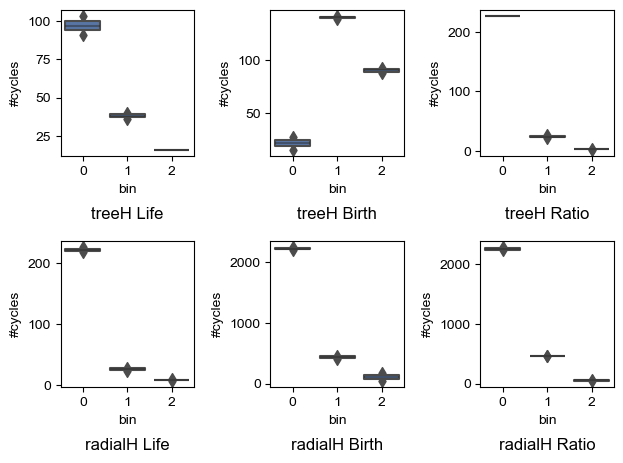

In [21]:
# boxplot
fix,ax = plt.subplots(len(modes),3)
for i,mode in enumerate(modes):
    for j,t in enumerate(['Life','Birth','Ratio']):
        X = results[[f'{mode}H_{t}_0',f'{mode}H_{t}_1',f'{mode}H_{t}_2']].values
        vboxplot(X,ax=ax[i,j],title=f'{mode}H {t}')


## Computed results
Comutation of metrics must be executed first.

In [22]:
## select which subject to look at
k = 0
metrics = results.iloc[k]
CTID = metrics['CTID']
H = PHs[CTID]
print(metrics)


treeH_entropy          6.691775
treeH_Life_0                 91
treeH_Life_1                 36
treeH_Life_2                 16
tree_Life_bin0              1.0
tree_Life_bin1        20.561946
tree_Life_bin2        40.123891
tree_Life_bin3        59.685837
treeH_Birth_0                28
treeH_Birth_1               139
treeH_Birth_2                88
tree_Birth_bin0             0.0
tree_Birth_bin1       64.319207
tree_Birth_bin2      128.638414
tree_Birth_bin3      192.957621
treeH_Ratio_0               226
treeH_Ratio_1                26
treeH_Ratio_2                 3
tree_Ratio_bin0             0.0
tree_Ratio_bin1        0.333333
tree_Ratio_bin2        0.666667
tree_Ratio_bin3             1.0
radialH_entropy       10.733449
radialH_Life_0              225
radialH_Life_1               29
radialH_Life_2               10
radial_Life_bin0            1.0
radial_Life_bin1       2.333333
radial_Life_bin2       3.666667
radial_Life_bin3            5.0
radialH_Birth_0            2207
radialH_

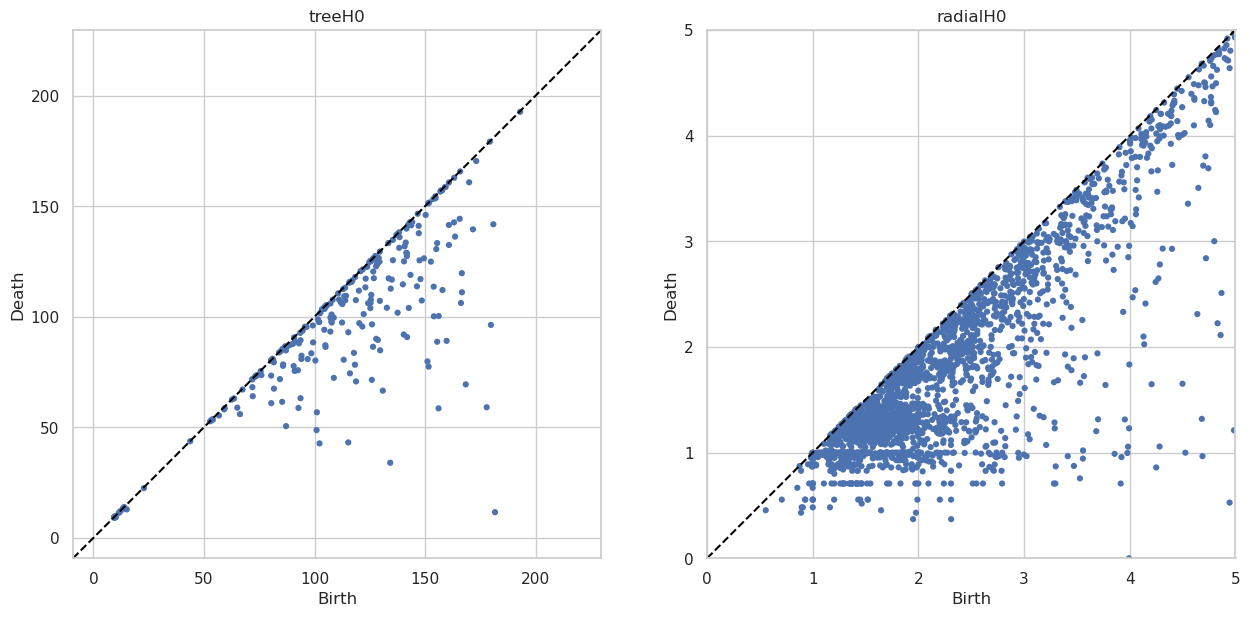

In [23]:
## plot persistence diagram
fig, ax= plt.subplots(1,2,figsize=(15,8))
persim.plot_diagrams(np.abs(H["tree"][:,1:3]),legend=False, lifetime=False, ax=ax[0],title="treeH0")
persim.plot_diagrams(np.abs(H["radial"][:,1:3]),xy_range=(0,max_life["radial"],0,max_life["radial"]), legend=False, lifetime=False, ax=ax[1],title="radialH0")


### Create a volume containing labels for PH cycles

use ITK-snap for visualisation: load the original CT as the main volume and the output of this as segmentation

http://www.itksnap.org/pmwiki/pmwiki.php


In [24]:
## annotation type
annot_type = 'fill' # fill, line
annot_metric = "life" # life, birth, ratio

# print information
verbosity = 0


In [25]:
# output filename
outfn = os.path.join(output_dir,f'{CTID}_{mode}_{annot_metric}_{annot_type}_gen1-{max_gen}.nrrd')

# load the original volume
volume, header = nrrd.read(input_files[k], index_order='C')
skeleton_generation,volume_generation,trachea_removed,origin = create_generation_volumes(volume,CTID,graph_creation="nx",remove_trachea=remove_trachea,verbose=verbosity,save_intermediate=False)
skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
for mode in modes:
    annotated = annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, verbosity)
    nrrd.write(outfn, annotated, index_order='C')
    print(f'successfully created {outfn}')

The root is located at  (111, 185, 174)
maximum generation 18, #connected components 1, #vertices 347, #edges 346, #leaves 163


  0%|          | 0/255 [00:00<?, ?it/s]

cycle counts:  [91. 36. 16.]
label counts [(2, 0.049459236354987196), (3, 0.08099562072390973), (4, 0.08253466343934072), ('none', 0.7870104794817624)]
successfully created output/Test01_radial_life_fill_gen1-30.nrrd


  0%|          | 0/2798 [00:00<?, ?it/s]

cycle counts:  [225.  29.  10.]
label counts [(2, 0.023043666839226002), (3, 0.008758552180543703), (4, 0.0034558504610132496), ('none', 0.9647419305192171)]
successfully created output/Test01_radial_life_fill_gen1-30.nrrd


# Utility

In [ ]:
# check the volume
import ipyvolume as ipv
ipv.quickvolshow(binarised_volume, data_min=0, data_max=1)


In [ ]:
# check the skeleton
ipv.quickvolshow(skeleton, data_min=0, data_max=1)

In [ ]:
# check distance transform
ipv.quickvolshow(dist_vol["tree"], data_min=0, data_max=1)